In [1]:
# import standard modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = (20, 10)

# Topic 2 - Propagation of errors

## Motivation

Suppose that we have measured some quantities $x_{1}, \dots, x_{n}$, and using these values wish to compute
$y = f(x_{1},\dots,x_{n})$ with $f$ a given function. All measurements are subject to 
random errors, and so we should ask how these uncertainties are propagated through to $y$.
The simplest and most general way to address this problem is through random sampling. We also discuss 
an analytical method that is approximate but useful when the errors are sufficiently small. 

## Setting up a simple statistical model

We group the $x_{1},\dots,x_{n}$ into an $n$-dimensional vector $\mathbf{x}$, and assume that 
the observed value is a sample from probability distribution $P$. For definiteness, we take
this to be a **multivariate normal distribution** which is characterised by a mean 
value $\bar{\mathbf{x}}$ and a covariance matrix $\mathbf{C}$. The covariance matrix
has dimension $n\times n$ and is required to be symmetric and positive-definite (meaning that all its eigenvalues
are positive).

The code below sets up such a distribution for $n = 2$ and plots samples from it. Again, we make use of the 
`scipy.stats` library, using in particular:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html#scipy.stats.multivariate_normal

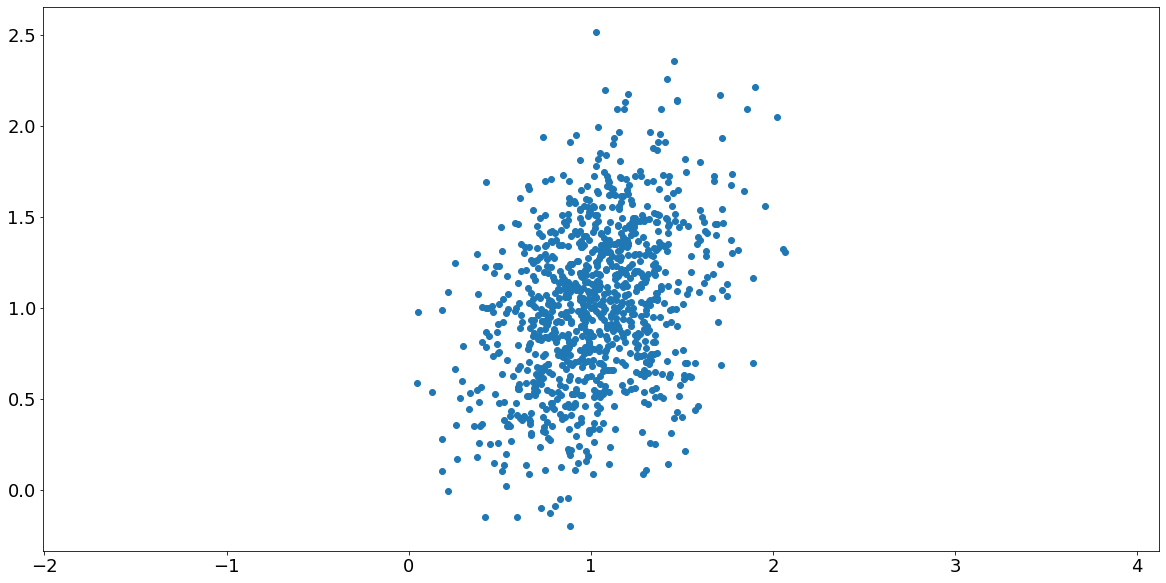

In [2]:
# Set the mean vector
xbar = np.array([1,1])

# Set the covariance
C = np.array([[0.1, 0.05],[0.05, 0.2]])

# Set up the distribution
X = stats.multivariate_normal(xbar,C)

# Draw samples from the distribution and plot them
nSamples = 1000
samples = X.rvs(nSamples)
x1 = samples[:,0]
x2 = samples[:,1]
plt.scatter(x1,x2)
plt.axis("equal")
plt.show()

Now we can sample from the distribution for $\mathbf{x}$, all we need do is evaluate
$f(\mathbf{x})$ to build up random samples for the distribution for $y = f(\mathbf{x})$. This is shown below for a simple choice of $f$, and with the resulting values plotted in a histogram.

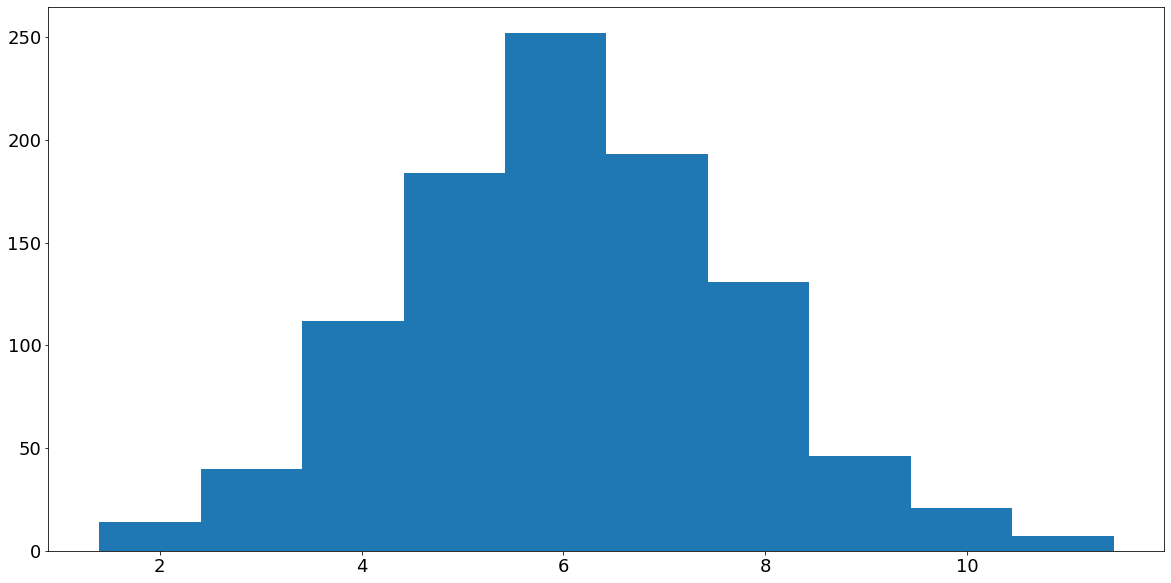

In [3]:
# Define the function
f = lambda x1,x2 : 1 + 2*x1 + 3*x2

# Evaluate f on the samples and plot a histogram 
fSamples = f(x1,x2)
plt.hist(fSamples)
plt.show()

Using the the sampled values of $y$, a range of statistical methods can be used to determine 
properties of the underlying distribution. For example, we can compute the mean and standard deviation as
follows using `numpy` functions:

In [4]:
# Compute the mean and standard deviation 
ybar = np.average(fSamples)  
sigma = np.std(fSamples)
print("mean = %7.4f, std = %7.4f" % (ybar,sigma))

mean =  6.0631, std =  1.6631


One particularly useful thing to compute from the sampled values is the **empirical cummulative distribution function (eCDF)**. For sampled values $y_{1},\dots y_{n}$ this is defined through

$
\hat{F}_{Y}(y) = \frac{\mbox{number of samples $\le y$}}{n}.
$

As the sample size increases, this function converges quite rapidly to the true **cummulative distribution 
function (CDF)**, $F_{Y}(y)$, for the distribution. Here we recall that the CDF is defined such that the
probability that $y$ lies in an interval $[a,b]$ can be written

$
P_{Y}([a,b]) = F_{Y}(b) - F_{Y}(a).
$

The code below computes and plots the eCDF from our sampled values using:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ecdf.html


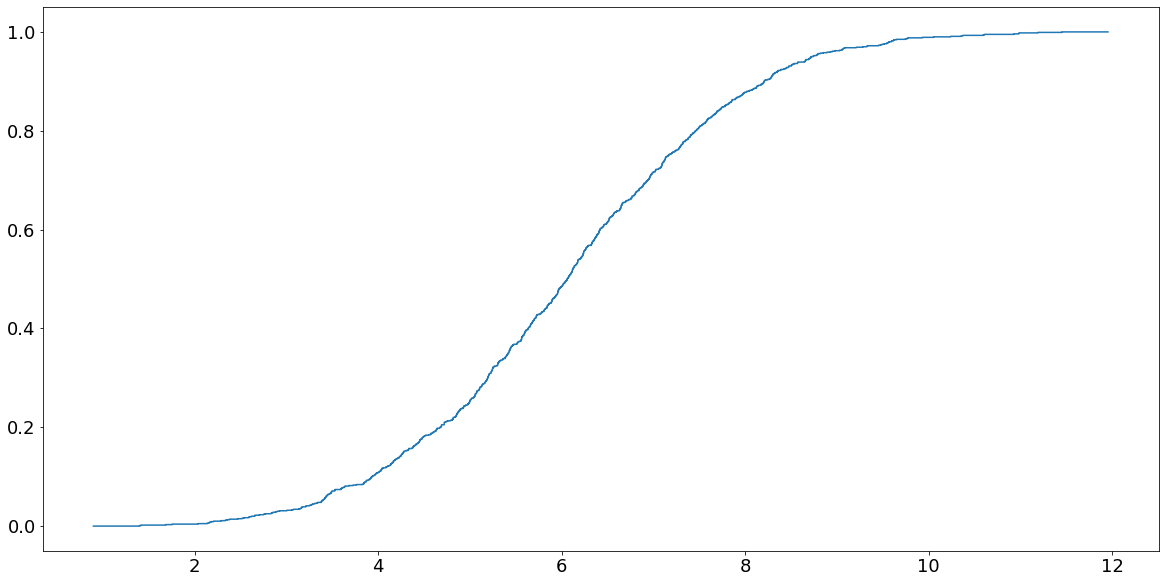

In [5]:
# Form and plot the eCDF
stats.ecdf(fSamples).cdf.plot()
plt.show()

You might like to try running the above codes using different values for `nSamples`, and see how this affects
the form of the eCDF.

## Linearised error propagation

Looking at the sampled values of $y = f(\mathbf{x})$ above within the histogram, it may have occurred that 
the values look normally distributed. We can test this by plotting the histogram again while also showing the PDF for a normal distribution using the computed mean and standard deviation:

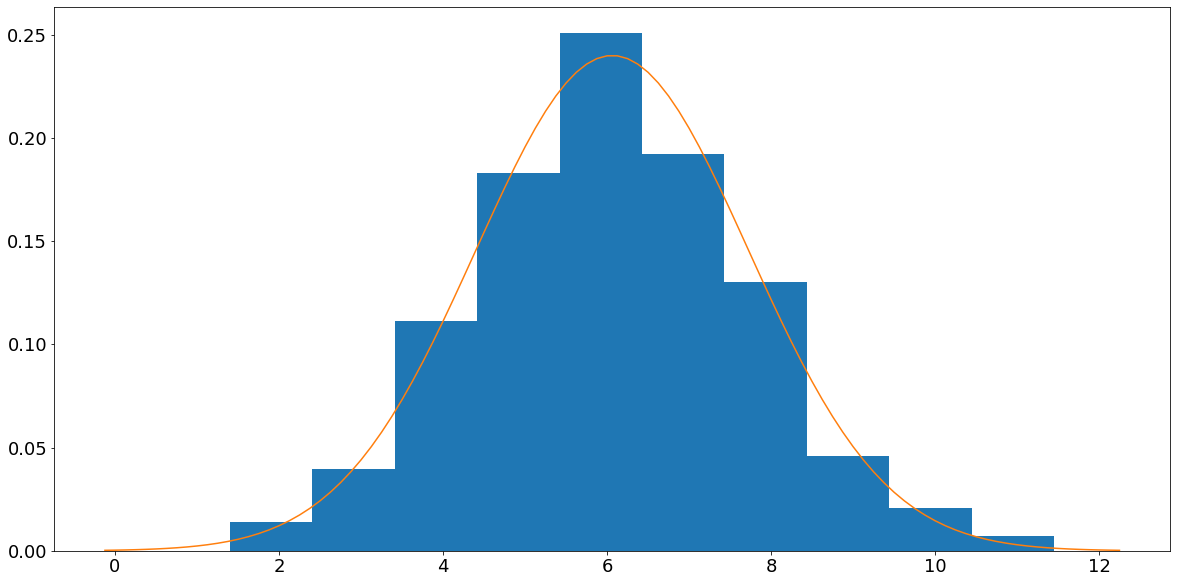

In [6]:
plt.hist(fSamples,density=True)
Y = stats.norm(loc = ybar, scale = sigma)
yy = np.linspace(Y.ppf(0.0001),Y.ppf(0.9999),100)
plt.plot(yy,Y.pdf(yy))
plt.show()

The fit should be pretty convincing so long as `nSamples` is set high enough. We will see below that 
this property need not always hold. But in those cases where it does, we can estimate the
form of this normal distribution without needing to apply random sampling. 

To proceed, we write $\mathbf{x}$ in the form

$
\mathbf{x} = \bar{\mathbf{x}} + \mathbf{z}, 
$

where $\mathbf{z}$ is, by definition, a sample from a  distribution with zero-mean. If we put this into 
$y = f(\mathbf{x})$ and use a first-order Taylor expansion we can write

$
y \approx f(\bar{\mathbf{x}}) + \mathbf{z} \cdot \nabla f (\bar{\mathbf{x}})
$

From this result, it can be shown that the mean value of $y$ is given by

$
\bar{y} = f(\bar{\mathbf{x}}),
$

while its standard deviation satisfies

$
\sigma_{y}^{2} =  \nabla f (\bar{\mathbf{x}})^{T} \,\mathbf{C}\,   \nabla f (\bar{\mathbf{x}}).
$

The derivation of these results will not be given, but you are welcome to ask if interested. A key point, however, 
is that the validity of  linearising about $\bar{\mathbf{x}}$ relies on the assumption that sampled
values of $\mathbf{z}$ are sufficiently small that higher-order
terms do not contribute appreciably. This condition depends both on the form of $f$ and on the distribution
of $\mathbf{z}$.

A simplification to the above formula occurs when errors on the components of $\mathbf{x}$ are 
uncorrelated. This means that the covariance matrix is diagonal, taking the form

$
\mathbf{C} = \mathrm{diag}(\sigma_{1}^{2}, \dots, \sigma_{n}^{2}). 
$

In this case, we can then write the standard deviation of $y$ in the simpler form

$
\sigma_{y}^{2} = \sum_{i=1}^{n} \left[\frac{\partial f}{\partial x_{i}}(\bar{\mathbf{x}})\right]^{2} \sigma_{1}^{2}.
$

The code below applies this idea to estimate the mean and standard deviation of $y$, with these values
compared to the results from random sampling. Here we use some standar `numpy` functions for 
matrix multiplication and for dot products. 

In [7]:
# Form the gradient of f noting the function is linear. 
gradient = np.array([2,3])

# estimate the mean and std
ybar2 = f(xbar[0],xbar[1])
sigma2 = np.sqrt(np.dot(np.matmul(C,gradient),gradient))
print("From random sampling: mean = %7.4f, std = %7.4f" % (ybar,sigma))
print("From linearisation:   mean = %7.4f, std = %7.4f" % (ybar2,sigma2))

From random sampling: mean =  6.0631, std =  1.6631
From linearisation:   mean =  6.0000, std =  1.6733


So long as `nSamples` is sufficiently large, the two methods should agree well. In fact, the 
analytical result is exact in this case because $\mathbf{x}$ is normally distributed and $f$
is an affine function (meaning a linear function plus a constant shift). The code below applies the same methods
to a more complicated function, and here we see the limitations of linearised error propagation. 

From random sampling: mean =  2.7631, std =  2.1844
From linearisation:   mean =  2.0000, std =  1.6733


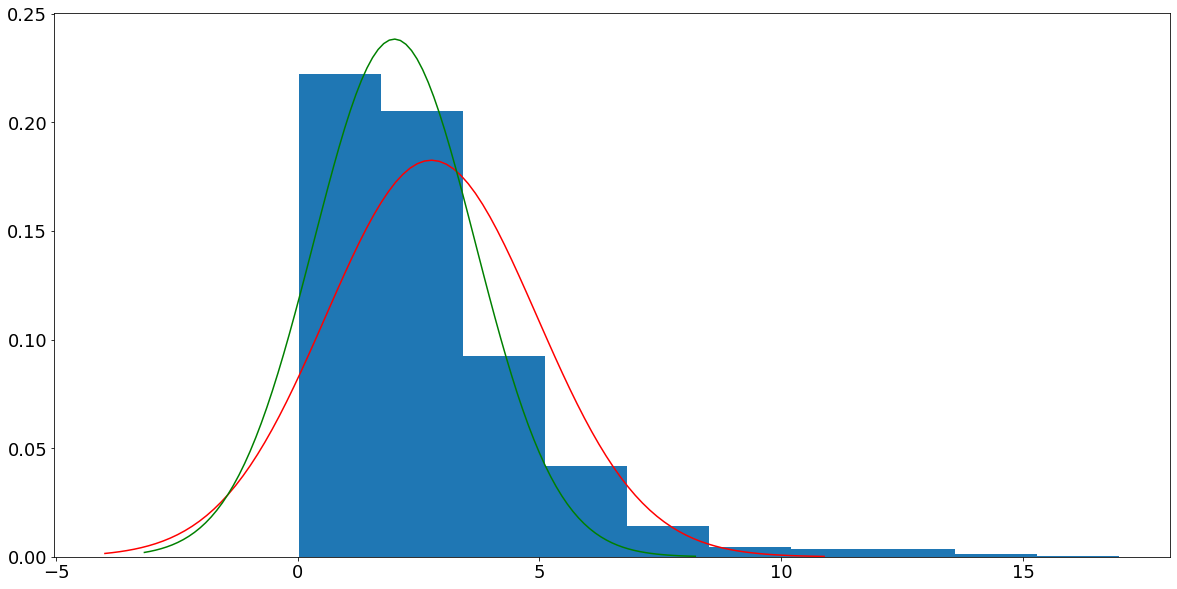

In [8]:
# Define the a new function
f = lambda x1,x2 : x1**2 + x2**3

# Evaluate f on the samples and plot a histogram 
fSamples = f(x1,x2)
plt.hist(fSamples,density = True)

# compute the mean and std using the sampled values
ybar = np.average(fSamples)  
sigma = np.std(fSamples)

# plot a normal distribution onto the histogram
Y = stats.norm(loc = ybar, scale = sigma)
yy = np.linspace(Y.ppf(0.001),Y.ppf(0.9999),100)
plt.plot(yy, Y.pdf(yy),'r')

# Define the gradient function in this case
df = lambda x1,x2 : np.array([2*x1, 3*x2**2])

# compute the mean and std using linearised formulae
ybar2 = f(xbar[0],xbar[1])
gradient  = df(xbar[0],xbar[1])
sigma2 = np.sqrt(np.dot(np.matmul(C,gradient),gradient))

# plot a normal distribution onto the histogram
Y = stats.norm(loc = ybar2, scale = sigma2)
yy = np.linspace(Y.ppf(0.001),Y.ppf(0.9999),100)
plt.plot(yy, Y.pdf(yy),'g')

print("From random sampling: mean = %7.4f, std = %7.4f" % (ybar,sigma))
print("From linearisation:   mean = %7.4f, std = %7.4f" % (ybar2,sigma2))


# plot normal distributions onto the histogram
plt.show()

In this case, we see that the samples of $y$ have a distinctly non-Gaussian form. The mean and standard deviations obtained by random sampling are still accurate (so long as `nSamples` is large enough). But these two parameters alone are insufficient to characterise the distribution. 

This issue with applying the linearised formulae in this instance is that $f$ cannot be well-approximated by a linear function for the range of values sampled by $\mathbf{x}$. If, however, the variation in $\mathbf{x}$ were more narrowly focused about its mean, we should expect linearisation to work well. As a exercise, you should vary the covariance matrix $\mathbf{C}$ suitably to see if this works as claimed. 